**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Nested CV](#2-bullet)
3. [Retrain and Evaluate Model](#3-bullet)

## 1. [Libraries and settings](#1-bullet)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import datetime as dt

from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('LCS DATASET PATH', sep='\t', index_col=0)

In [3]:
df['TradingDate'] = pd.to_datetime(df['TradingDate'], format='%Y-%m-%d')

In [4]:
df = df.dropna()

In [5]:
# Create a new dataframe
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

In [6]:
# scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [7]:
scaled_data

array([[ 4.06607813],
       [ 4.07990553],
       [ 3.9416315 ],
       ...,
       [-1.11919787],
       [-1.11919787],
       [-1.11919787]])

## 2. [Nested CV - Predict Second Half](#2-bullet)

We try to use nested CV for time series to try to tune hyperparameters. After getting best hyperparameters, we retrain model and then evaluate

### Create dataset

In [8]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
time_step = 30
x_for_train, y_for_train = create_dataset(scaled_data, time_step)

x_for_train =x_for_train.reshape(x_for_train.shape[0],x_for_train.shape[1])
y_for_train = y_for_train.reshape(y_for_train.shape[0],1)

### Predict Second Half

In [10]:
def performSVR(X_train, Y_train, X_test, Y_test, parameters):

    # Create and train the SVR model
    svr_model = SVR(C = parameters['C'], kernel = parameters['kernel'], gamma = parameters['gamma'])
    svr_model.fit(X_train, Y_train)

    # Make predictions on the test set
    Y_pred_train = svr_model.predict(X_train)
    Y_pred_test = svr_model.predict(X_test)

    # Calculate accuracy
    accuracy_train = r2_score(Y_train, Y_pred_train)
    accuracy_valid = r2_score(Y_test, Y_pred_test)

    mse_train = mean_squared_error(Y_train, Y_pred_train)
    mse_valid = mean_squared_error(Y_test, Y_pred_test)

    return [accuracy_train, accuracy_valid, mse_train, mse_valid]

In [11]:
def predict_second_half(X, y, params):
    train_size = len(X) // 2
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.5, shuffle=False)

    # Assuming you have a validation set stored in variables called 'val_data' and 'val_target'
    # Splitting the training set into training and validation subsets
    X_sub_train, x_val, y_sub_train, y_val = train_test_split(X_train, y_train, test_size=0.5, shuffle=False)

    # Training and evaluating the model
    accuracy_train, accuracy_valid, mse_train, mse_valid = performSVR(X_sub_train, y_sub_train, x_val, y_val, params)


    return accuracy_train, accuracy_valid, mse_train, mse_valid



In [12]:
from sklearn.model_selection import ParameterGrid

# Định nghĩa siêu tham số để tinh chỉnh
param_grid = {
    'C': [0.01, 0.1, 1, 100],
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma' : [0.01, 0.001, 1]
}

# Chuyển đổi siêu tham số thành danh sách các tham số có thể
param_list = list(ParameterGrid(param_grid))

# Lưu kết quả của các mô hình đã được đánh giá
results = []

# Lặp qua từng bộ tham số để đánh giá mô hình
for i,params in enumerate(param_list):
    print(f"Evaluating parameters {i+1}: {params}")

    # Thực hiện Cross Validation với mô hình SVR và siêu tham số tương ứng
    accuracy_train, accuracy_valid, mse_train, mse_valid = predict_second_half(x_for_train, y_for_train, params)

    # Lưu kết quả vào danh sách
    results.append({
        'parameters': params,
        'accuracy_train': accuracy_train,
        'accuracy_valid': accuracy_valid,
        'mse_train': mse_train,
        'mse_valid': mse_valid
    })

# In kết quả của các mô hình đã đánh giá
for result in results:
    print("Parameters: ", result['parameters'])
    print("Train Accuracy: ", result['accuracy_train'])
    print("Valid Accuracy: ", result['accuracy_valid'])
    print("Train MSE: ", result['mse_train'])
    print("Valid MSE: ", result['mse_valid'])
    print("------------------------")

# Sắp xếp danh sách kết quả theo trường 'accuracy_valid' tăng dần
sorted_results = sorted(results, key=lambda x: x['mse_valid'], reverse=False)

# Lấy bộ tham số đầu tiên từ danh sách đã sắp xếp
best_parameters = sorted_results[0]['parameters']

# In ra bộ tham số có accuracy_valid lớn nhất
print("Best Parameters: ", best_parameters)

Evaluating parameters 1: {'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}
Evaluating parameters 2: {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
Evaluating parameters 3: {'C': 0.01, 'gamma': 0.01, 'kernel': 'sigmoid'}
Evaluating parameters 4: {'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}
Evaluating parameters 5: {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
Evaluating parameters 6: {'C': 0.01, 'gamma': 0.001, 'kernel': 'sigmoid'}
Evaluating parameters 7: {'C': 0.01, 'gamma': 1, 'kernel': 'linear'}
Evaluating parameters 8: {'C': 0.01, 'gamma': 1, 'kernel': 'rbf'}
Evaluating parameters 9: {'C': 0.01, 'gamma': 1, 'kernel': 'sigmoid'}
Evaluating parameters 10: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Evaluating parameters 11: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Evaluating parameters 12: {'C': 0.1, 'gamma': 0.01, 'kernel': 'sigmoid'}
Evaluating parameters 13: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Evaluating parameters 14: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
Evaluat

## 3. [Retrain and Evaluate Model](#4-bullet)

### Create training and testing data

In [13]:
training_size=int(len(dataset)*0.5)
test_size=len(dataset)-training_size
train_data,test_data=scaled_data[0:training_size],scaled_data[training_size:len(dataset)]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1768, 1)
test_data:  (1769, 1)


In [14]:
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1])
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1])
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (1737, 30)
y_train:  (1737, 1)
x_test:  (1738, 30)
y_test (1738, 1)


### Building model

Using best hyperparameters after tuning to retrain model

In [15]:
# Create and train the SVR model
svr_model = SVR(C = 1, kernel = 'linear', gamma = 0.01)
svr_model.fit(x_train, y_train)

SVR(C=1, gamma=0.01, kernel='linear')

In [16]:
predictions = svr_model.predict(x_test)
predictions = predictions.reshape(-1,1)


predictions_train = svr_model.predict(x_train)
predictions_train = predictions_train.reshape(-1,1)


In [17]:
predictions = scaler.inverse_transform(predictions)
predictions_train = scaler.inverse_transform(predictions_train)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [18]:
column_names_pred = ['Close_predict']
df_predictions = pd.DataFrame(predictions, columns=column_names_pred)

column_names_test = ['Close_test']
df_test = pd.DataFrame(y_test, columns=column_names_test)

concatenated = np.concatenate([df_predictions, df_test], axis=1)
column_names_concat = ['Close_predict', 'Close_test']
df_concatenated = pd.DataFrame(concatenated, columns = column_names_concat)

In [19]:
df_concatenated

,Close_predict,Close_test
0,2854.443251,2800.0
1,2851.161491,2800.0
2,2826.543177,2800.0
3,2796.273049,2700.0
4,2775.942553,2700.0
...,...,...
1733,648.256823,600.0
1734,631.227389,600.0
1735,660.690960,600.0
1736,640.581796,600.0


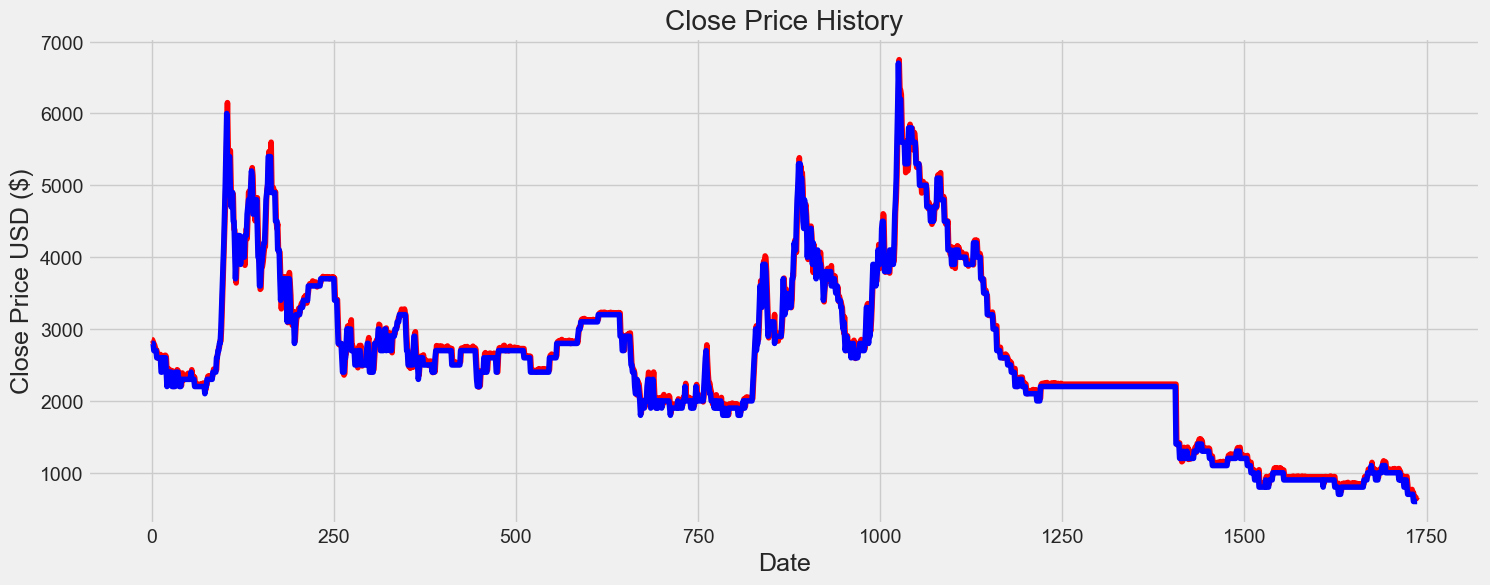

In [20]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df_predictions['Close_predict'], color='red', label='Predicted Close Price')
plt.plot(df_test['Close_test'], color='blue', label='Actual Close Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

### Evaluate model

In [21]:
predictions = scaler.fit_transform(predictions)
predictions_train = scaler.fit_transform(predictions_train)
y_test = scaler.fit_transform(y_test)
y_train = scaler.fit_transform(y_train)

In [22]:

mae_train = mean_absolute_error(y_train, predictions_train)
rmse_train = mean_squared_error(y_train, predictions_train)
r2_train = r2_score(y_train, predictions_train)

print("Train Mean Absolute Error:", mae_train)
print("Train Mean Squared Error:", rmse_train)
print("Train R-squared:", r2_train)

Train Mean Absolute Error: 0.05026181140537202
Train Mean Squared Error: 0.006394758246602767
Train R-squared: 0.9936052417533973


In [23]:
mae_test = mean_absolute_error(y_test, predictions)
rmse_test = mean_squared_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)

print("Test Mean Absolute Error:", mae_test)
print("Test Mean Squared Error:", rmse_test)
print("Test R-squared:", r2_test)

Test Mean Absolute Error: 0.054722321257731736
Test Mean Squared Error: 0.010468504494660677
Test R-squared: 0.9895314955053394
